In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

from shapely import Polygon
import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import beampipe_parameters
beampipe0=beampipe_parameters.Beampipe()

In [6]:

#def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=59.8, width=59.6,gap=0.4):
# def layer_boundaries(layer=0, side="L", beampipe=beampipe0, height=60.96, width=60.96,gap=0.4):
#     offsetX=-10
#     holeX=beampipe.holeX(layer)
#     holeR=beampipe.holeR(layer)
#     if side=="R":
#         offsetX-width/2
        
#         phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
#         x,y = [offsetX-width/2, offsetX-width/2, -gap/2, -gap/2] + list(holeX-holeR*np.cos(phi)) + [-gap/2,-gap/2, -39.8], \
#                  [-height/2,height/2, height/2, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-height/2, -height/2]
#         return Polygon(zip(x,y))
#     if side=="L":
        
#         phi0 = np.arccos((holeX-gap/2)/holeR)
#         #print((np.pi-phi0)/np.pi*2)
#         phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
#         x=[offsetX+width/2, offsetX+width/2, gap/2] + list(holeX-np.cos(phi)*holeR) + [gap/2, 19.8]
#         y=[-height/2,height/2, height/2]+list(holeR*np.sin(phi)) + [-height/2, -height/2]
#         return Polygon(zip(x,y))

from boundaries import layer_boundaries

In [7]:
def dimension(x, y, slashlength=1, position_ratio=0.5):
    #draw line
    plt.plot(x, y,color='0.5', linestyle='-')
    #draw slashes
    for i in 0,1:
        plt.plot([x[i]-slashlength/2, x[i]+slashlength/2], 
                 [y[i]-slashlength/2, y[i]+slashlength/2], color='0.5', linestyle='-', linewidth=3)

    #now write the dimension
    dist = np.hypot(x[1]-x[0], y[1]-y[0])
    pr=position_ratio
    phi=-np.arctan2(y[1]-y[0], x[1]-x[0])
    plt.text(x[0]*pr+x[1]*(1-pr), y[0]*pr+y[1]*(1-pr), 
             f"{dist:.2f} cm\n{dist/2.54:.2f}\"", ha='center', va='center',
            rotation=phi*180/np.pi)

In [10]:

def engineering_diagram(layer, beampipe=beampipe0, height=60.96, width=60.96,
                        gap_between_sides=0.4, gap_for_backplanes=0.4, backplanes_in_holes=False):
    fig, ax=plt.subplots(1,1,figsize=(16,16))
    plt.text(-10, 27, f"Layer {layer}", ha='center', fontsize=40)
    phi = np.linspace(-np.pi, np.pi, 7)
    boundaries={}
    for side in "LR":
        boundaries[side]=layer_boundaries(layer, side, beampipe=beampipe, height=height, width=width, 
                                          gap_between_sides=gap_between_sides, 
                                          gap_for_backplanes=gap_for_backplanes, 
                                          backplanes_in_holes=backplanes_in_holes)
        
        plt.plot(*boundaries[side].exterior.xy, linestyle='-', color='k', linewidth=2)
        plt.fill(*boundaries[side].exterior.xy, color='#33aaff11')
    offset=-10
    
    
    gap=gap_between_sides+2*gap_for_backplanes
    
    #right to left
    dimension([offset-width/2, offset+width/2], [-height/2+3, -height/2+3])
    
    #top to bottom
    dimension([offset-width/2+5, offset-width/2+5], [height/2, -height/2], position_ratio=0.3)
    
    #right to gap
    dimension([offset-width/2, -gap/2], [22,22])
    
    #left to gap
    dimension([gap/2, offset+width/2], [25,25])
    
    #center to left
    dimension([beampipe.holeX(layer), offset+width/2], [0,0], position_ratio=0.25)
    #center to right
    dimension([offset-width/2, beampipe.holeX(layer)], [0,0], position_ratio=0.6)
    
    phi=0.7*np.pi
    x=beampipe.holeX(layer)
    r=beampipe.holeR(layer)
    #center to hole
    dimension([x+np.cos(phi)*r,x], [np.sin(phi)*r,0])
    
    #now show the gap dimensions using inward-pointing arrows
    arg=dict(color='0.5', linestyle='-')
    h=-24 #height of where the dimension goes
    ah=0.5 #arrowhead
    plt.plot([-2, -gap/2], [h, h], **arg)
    plt.plot([-gap/2-ah, -gap/2, -gap/2-ah], [h+ah, h, h-ah],**arg)
    
    plt.plot([2, gap/2], [h, h],**arg)
    plt.plot([gap/2+ah, gap/2, gap/2+ah], [h+ah, h, h-ah],**arg)
    
    plt.text(6, h, f"{gap:.2f} cm\n{gap/2.54:.2f}\"", va='center', ha='center')
    
    
    if  backplanes_in_holes:
        #now show the dimension for the additional gap for the inner backplanes:
        ah=0.5 #arrowhead
        holeX=beampipe.holeX(layer)
        holeR=beampipe.holeR(layer)
        shift=-2
        plt.plot([holeX-shift]*2, [holeR, holeR-2], **arg)
        plt.plot([holeX-shift-ah, holeX-shift, holeX-shift+ah], [holeR-ah, holeR, holeR-ah], **arg)

        plt.plot([holeX-shift]*2, [holeR+gap_for_backplanes, holeR+gap_for_backplanes+2], **arg)
        plt.plot([holeX-shift-ah, holeX-shift, holeX-shift+ah], 
                 [holeR+gap_for_backplanes+ah, holeR+gap_for_backplanes, holeR+gap_for_backplanes+ah], **arg)

        plt.text(holeX-shift, holeR-5, f"{gap_for_backplanes:.2f} cm\n{gap_for_backplanes/2.54:.2f}\"", va='center', ha='center')

        shift=-3
        dimension([holeX,-gap/2], [-holeR-gap_for_backplanes+shift]*2, position_ratio=0.6)

    
    ax.invert_xaxis()
    ax.axis("off")
    return fig, ax
    #plt.plot(
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

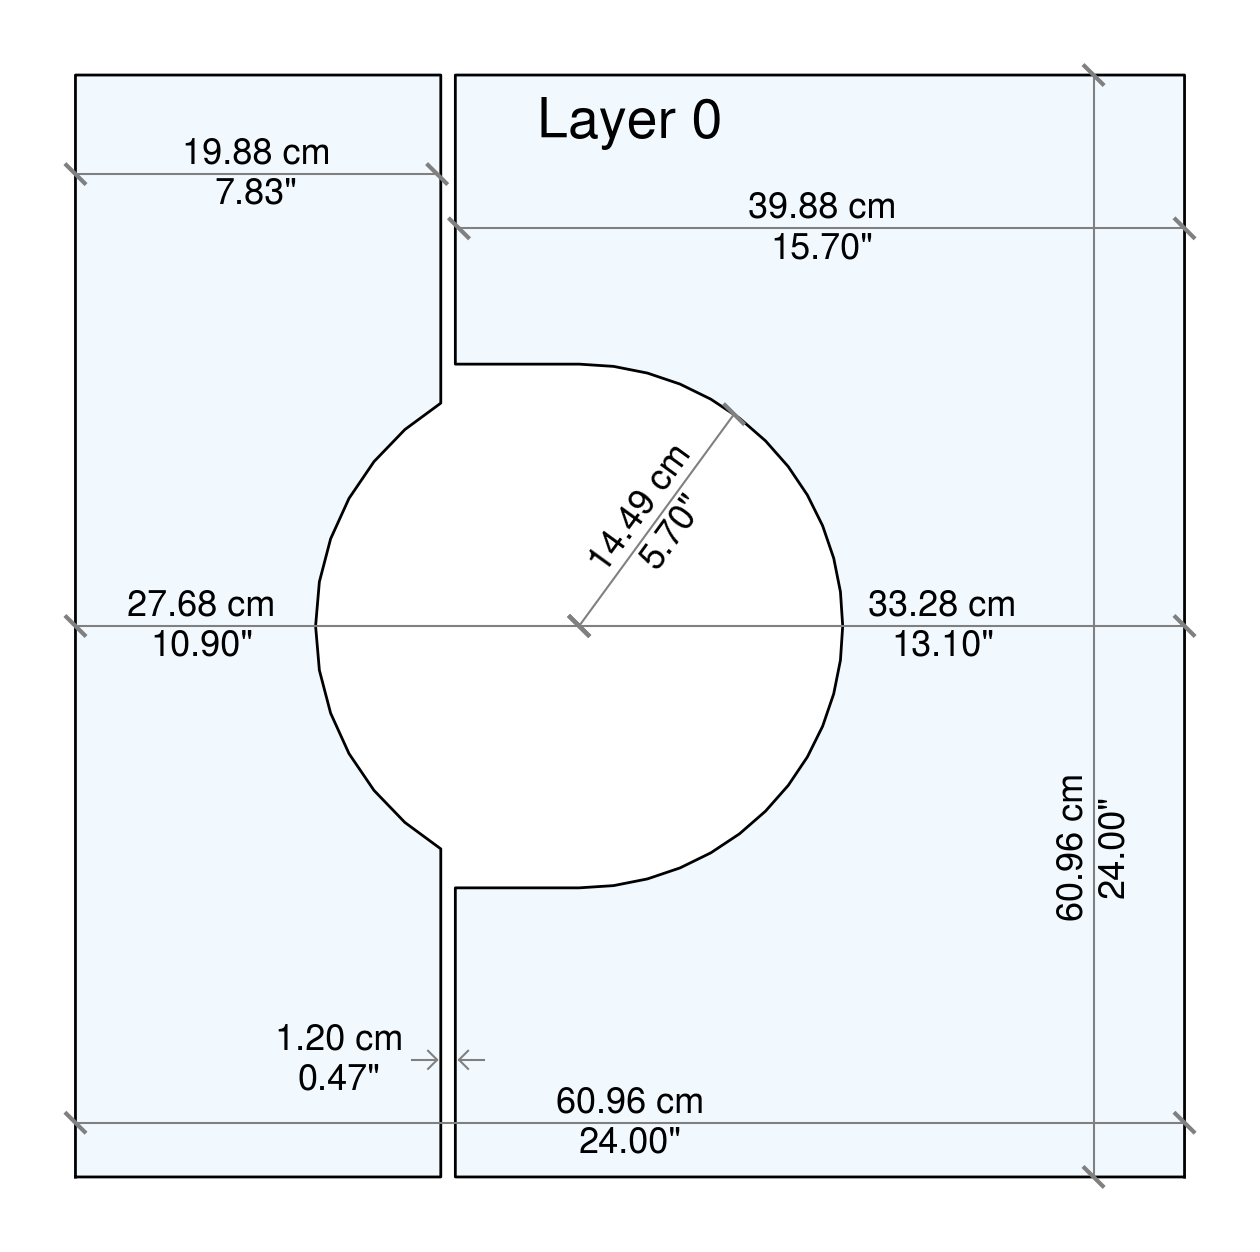

(<Figure size 1600x1600 with 1 Axes>, <AxesSubplot:>)

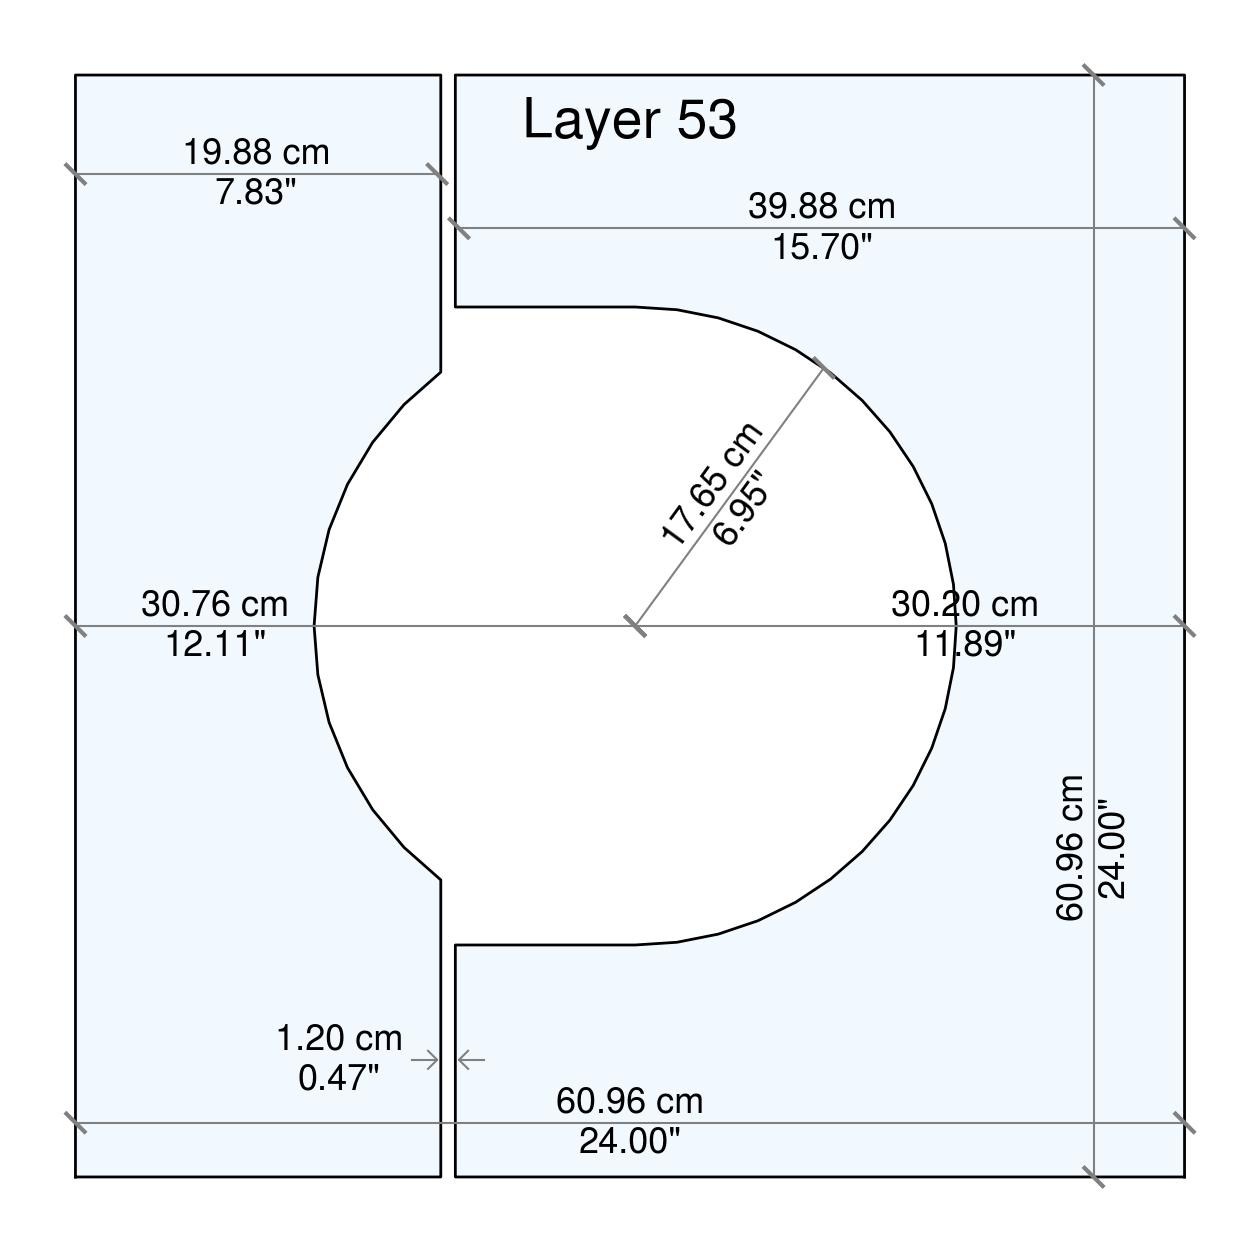

In [66]:


engineering_diagram(0, width=60.96, height=60.96)
plt.show()
engineering_diagram(53, width=60.96, height=60.96)


In [67]:
def draw_backplanes(beampipe=beampipe0,height=60.96, board_shape='rect', include_inner=False):
    
    nabsorbers=55
    
    if include_inner:
        fig, axs=plt.subplots(6,1,figsize=(16,16+8), sharex=False)
    else:
        fig, axs=plt.subplots(4,1,figsize=(16,16), sharex=False)
    offset=10
    gap=0.4 #this is the gap between the two halves of the detector, which determines the dimensions of the backplanes
    
    #left top, left bottom, right top, right bottom
    for j in range(4):
        plt.sca(axs[j])
        holeX0=beampipe.holeX(0)
        holeR0=beampipe.holeR(0)
        z0=beampipe.getZ(0)
        phi0 = np.arccos((holeX0-gap/2)/holeR0)
        y0=holeR0*np.sin(phi0) if j <2 else holeR0


        holeX1=beampipe.holeX(nabsorbers)
        holeR1=beampipe.holeR(nabsorbers)
        z1=beampipe.getZ(nabsorbers)
        phi1 = np.arccos((holeX1-gap/2)/holeR1)
        y1=holeR1*np.sin(phi1) if j <2 else holeR1

        if board_shape=='rect':
            y0=min(y1, y0)
            y1=y0
        
        arg=dict(linestyle='-', color='k', linewidth=2)
        
        bounds = [z0, z1, z1, z0, z0], [y0, y1, height/2, height/2, y0]
        plt.plot(*bounds, **arg)
        plt.fill(*bounds, color='#33ffaa11')
        
        
        if board_shape=='trap':
            #mark which corners are right angles.  
            a=3
            plt.plot([z0, z0+a, z0+a, z0, z0], [height/2, height/2, height/2-a, height/2-a, height/2],**arg)
            plt.plot([z1, z1-a, z1-a, z1, z1], [height/2, height/2, height/2-a, height/2-a, height/2],**arg)
        
        
        
        dimension([z0-7, z0-7], [height/2, y0])
        dimension([z1+7, z1+7], [height/2, y1])
        dimension([z0,z1],[height/2+7, height/2+7])
        
        axs[j].axis("off")
        axs[j].set_xlim(z0-10, z0+150)
        axs[j].set_ylim(10, 50)
        txt=''
        if j%2:
            axs[j].invert_yaxis()
            txt+="bottom"
        else:
            txt+="top"
        if j<2:
            txt+=" left"
        else:
            axs[j].invert_yaxis()
            txt+=" right"
        
        
        plt.text((z0+z1)/2,(height/2-10) , txt, ha='center', va='center')
    
    if not include_inner:
        return
    #top inner right, bottom inner right
    for j in range(4,6):
        plt.sca(axs[j])
        holeX0=beampipe.holeX(0)
        holeR0=beampipe.holeR(0)
        z0=beampipe.getZ(0)
        phi0 = np.arccos((holeX0-gap/2)/holeR0)
        y0=-holeX0


        holeX1=beampipe.holeX(nabsorbers)
        holeR1=beampipe.holeR(nabsorbers)
        z1=beampipe.getZ(nabsorbers)
        phi1 = np.arccos((holeX1-gap/2)/holeR1)
        y1=-holeX1
        
        if board_shape=='rect':
            y0=min(y1, y0)
            y1=y0

        #take into account the tilt
        z1=z0+(z1-z0)/np.cos(np.arctan((holeR1-holeR0)/(z1-z0)))
        
        print(np.cos(np.arctan((holeR1-holeR0)/(z1-z0))))
        
        arg=dict(linestyle='-', color='k', linewidth=2)
        
        bounds = [z0, z1, z1, z0, z0], [y0, y1, 0, 0, y0]
        plt.plot(*bounds, **arg)
        plt.fill(*bounds, color='#33ffaa11')
        
        
        if board_shape=='trap':
            #mark which corners are right angles.  
            a=3
            plt.plot([z0, z0+a, z0+a, z0, z0], [0, 0, a, a, 0],**arg)
            plt.plot([z1, z1-a, z1-a, z1, z1], [0, 0, a, a, 0],**arg)
        
        
        dimension([z0-7, z0-7], [y0, 0])
        dimension([z1+7, z1+7], [y1, 0])
        dimension([z0,z1],[-7, -7])
        
        axs[j].axis("off")
        axs[j].set_xlim(z0-10, z0+150)
        axs[j].set_ylim(-10, 30)
        txt=''
        if j%2:
            txt+="bottom"
            axs[j].invert_yaxis()
        else:
            txt+="top"
        txt += " inner"
        txt+=" right"
        
        
        
        plt.text((z0+z1)/2,(y1+y0)/4 , txt, ha='center', va='center')

0.9996756198928943
0.9996756198928943


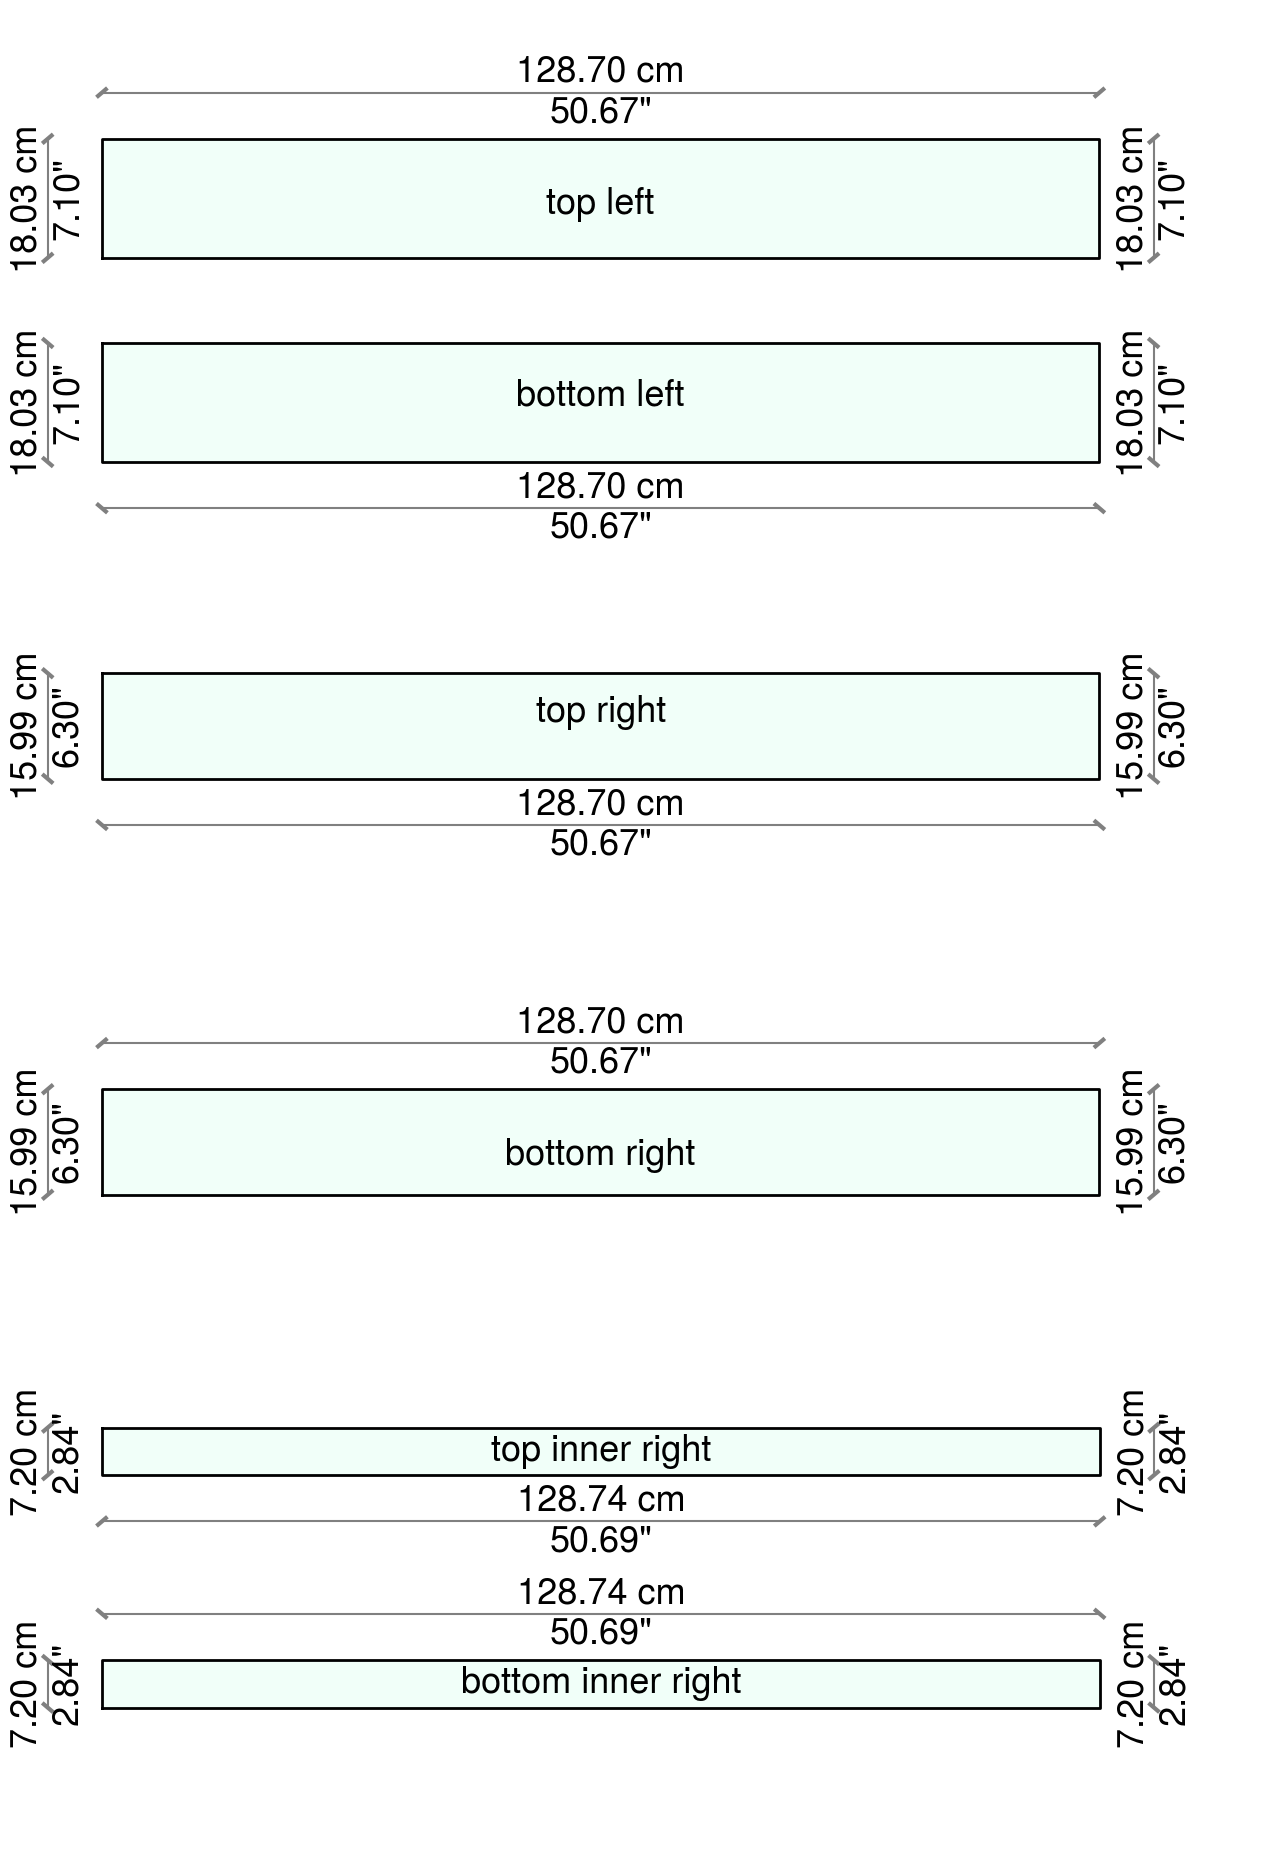

In [69]:
draw_backplanes(include_inner=True)

In [63]:
beampipe0.holeX(np.array([0, 59]))

array([ -7.2047662 , -10.63140297])